# Homework 5: Confusion Matrix. ROC. AUC.

# Part 1
You will predict for an insuarance company how likely the person will be admitted to a hospital within the next year `DaysInHospital_Y2.csv`. The following data is provided: paitients' information `Members.csv` (age, sex) medical services provided in the previous year `Claims_Y1.csv` (provider, doctor, illness, days in hospital, etc. ).
Data source: https://www.kaggle.com/competitions/hhp/overview

You can find the files on MyCourse, also you can dounload them directly from https://github.com/truongkhanhduy95/Heritage-Health-Prize/tree/master/data (click *Raw data* and copy the path).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#1. (2pt) Read the data using parameter index_col = `MemberID`.

* table 'DaysInHospital_Y2.csv' into variable `days2`
* table 'Members.csv' into variable `m`
* table 'Claims_Y1.csv' into variable `claims`

In [ ]:
m=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/Members.csv',index_col='MemberID')

In [ ]:
claims=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/Claims.csv',index_col='MemberID')
#claims.head()

In [ ]:
claims.head()

,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
MemberID,,,,,,,,,,,,,
42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,NaN,8- 9 months,NEUMENT,0,MED,0
97903248,3316066.0,726296.0,5300.0,Y3,Internal,Office,50,NaN,7- 8 months,NEUMENT,1-2,EM,0
2759427,2997752.0,140343.0,91972.0,Y3,Internal,Office,14,NaN,0- 1 month,METAB3,0,EM,0
73570559,7053364.0,240043.0,70119.0,Y3,Laboratory,Independent Lab,24,NaN,5- 6 months,METAB3,1-2,SCS,0
11837054,7557061.0,496247.0,68968.0,Y2,Surgery,Outpatient Hospital,27,NaN,4- 5 months,FXDISLC,1-2,EM,0


In [ ]:
days2=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/DaysInHospital_Y2.csv',index_col='MemberID')
days2.head()

,ClaimsTruncated,DaysInHospital
MemberID,,
24027423,0,0
98324177,0,0
33899367,1,1
5481382,0,1
69908334,0,0


To anonymize the data, the organizer provided approximate information about patients, for example, in the age column, age groups are specified: '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'. We will convert string features into numerical ones and replace missing values.

In [ ]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s.split('-')[0]) if s!='80+' else 80)

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})

Let's construct features based on the array of medical service cases:
* `f_Charlson` — the maximum Charlson comorbidity index among all cases for the patient (`CharlsonIndex` in the table `claims`)
* `f_LengthOfStay` —  the total number of hospitalization days in the past year  (`LengthOfStay` in the table `claims`)


In [ ]:
f_Charlson = claims.groupby(['MemberID'])['CharlsonIndex'].max()
f_LengthOfStay = claims.groupby(['MemberID'])['LengthOfStay'].sum()

We will create a feature matrix with the following columns: `f_Charlson`, `f_LengthOfStay`, `AgeAtFirstClaim`, `ClaimsTruncated` (whether there were too many medical service cases).

In [ ]:
y = (days2['DaysInHospital']>0).astype('int').values
X = days2[['ClaimsTruncated']]
X = X.join(f_Charlson)
X = X.join(f_LengthOfStay)
X = X.join(m.AgeAtFirstClaim)
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim
MemberID,,,,
24027423,0,3,0,30
98324177,0,0,0,30
33899367,1,0,0,80
5481382,0,0,1,20
69908334,0,1,0,60


## 2. (1pt) Add to the features columm `Sex`

In [ ]:
X = X.join(m.Sex)
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim,Sex
MemberID,,,,,
24027423,0,3,0,30,M
98324177,0,0,0,30,M
33899367,1,0,0,80,F
5481382,0,0,1,20,F
69908334,0,1,0,60,F


## 3. (1pt) Split the date X and y into Train/Validation/Test sets in the following proportion: 50/25/25.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, test_size=0.5, random_state=42)

In [ ]:
X_train.shape

(38019, 5)

In [ ]:
y_train.shape

(38019,)

In [ ]:
X_validation.shape

(19009, 5)

In [ ]:
y_validation.shape

(19009,)

In [ ]:
X_test.shape

(19010, 5)

In [ ]:
y_test.shape

(19010,)

In [ ]:
X_train.Sex

MemberID
78411929      M
98508908      M
70301481    NaN
56730824      M
24399252    NaN
           ... 
98981446    NaN
23520654    NaN
69877219      F
42414011      F
44296471      F
Name: Sex, Length: 38019, dtype: object

##4. (1pt) The column `Sex` contains missing values. Create the column transformer that will apply One-Hot-Encoder to this column with parameter `handle_unknown='infrequent_if_exist'`. It will create automatically `'OneHot__Sex_nan'` column afer fitting this transformer on the Train set.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
transform = ColumnTransformer([('OneHot', OneHotEncoder(handle_unknown='infrequent_if_exist'), ["Sex"])], remainder='passthrough')
transform.fit(X_train)
pd.DataFrame(transform.transform(X_train), columns=transform.get_feature_names_out()).head()

,OneHot__Sex_F,OneHot__Sex_M,OneHot__Sex_nan,remainder__ClaimsTruncated,remainder__CharlsonIndex,remainder__LengthOfStay,remainder__AgeAtFirstClaim
0,0.0,1.0,0.0,0.0,0.0,1.0,10.0
1,0.0,1.0,0.0,0.0,0.0,0.0,60.0
2,0.0,0.0,1.0,0.0,1.0,0.0,60.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,5.0,1.0,80.0


## 5. (1pt) Create a pipeline for training logistic regression. It should include transformation, scaling, and model. And fit it on the Training set

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [ ]:
pipe = Pipeline([('transformer', transform), ('scaler', StandardScaler()), ('model', LogisticRegression())])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['Sex'])])),
                ('scaler', StandardScaler()), ('model', LogisticRegression())])

## 6. (2pt) Plot ROC-AUC and Confusion Matrix. Report the Recall value.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, RocCurveDisplay, roc_curve

In [ ]:
y_predict_val = pipe.predict(X_validation)

In [ ]:
CM = confusion_matrix(y_validation, y_predict_val)

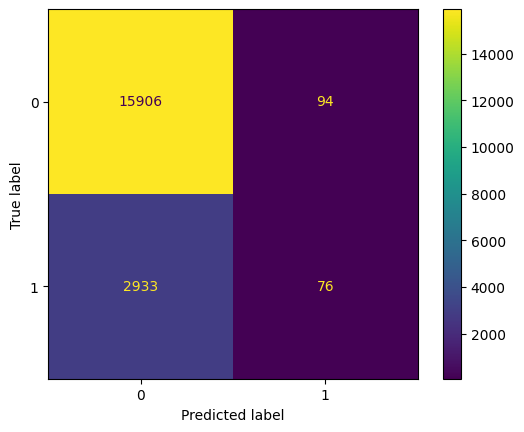

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_validation, y_predict_val)

In [ ]:
recall_score(y_validation, y_predict_val)

0.025257560651379195

In [ ]:
# y_score

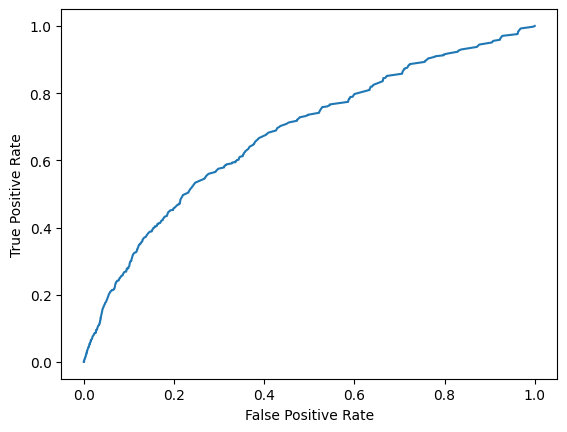

In [ ]:
y_score = pipe.decision_function(X_validation)
fpr, tpr, _ = roc_curve(y_validation, y_score, pos_label=pipe.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


## 7. (4pt) Use `.predict_proba` to get the values in the interval $[0,\ 1]$ instead of the classes 0 or 1.

Choose the threshold, such that recall on the Validation set is $>0.5$ (Think about this as the insuarance company's requirement.)

For the chosen threshold plot ROC-AUC and Confusion Matrix. Report the Recall value.

In [ ]:
y_predict_val_proba = pipe.predict_proba(X_validation)

In [ ]:
y_predict_val_proba[0]

array([0.91463293, 0.08536707])

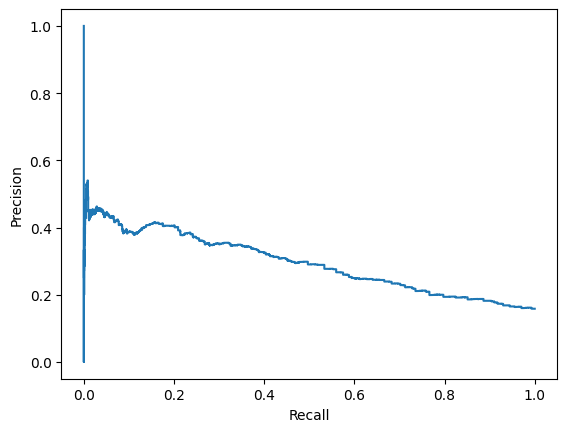

In [ ]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
precision, recall, thresh = precision_recall_curve(y_validation, y_predict_val_proba[:, 1])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

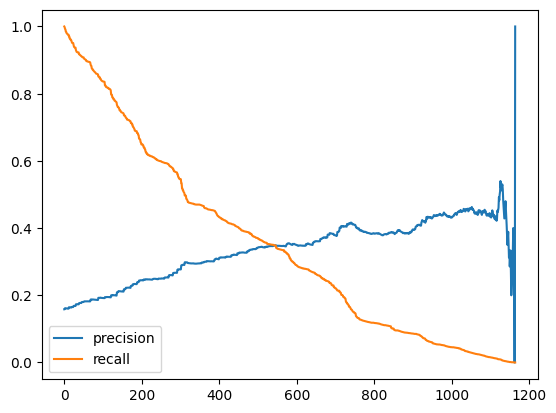

In [ ]:
plt.plot(precision, label='precision')
plt.plot(recall, label='recall')
plt.legend()

In [ ]:
# recall is > 0.5 with for a proba index <= 250
threshold = thresh[240]

In [ ]:
y_predict_val_proba

array([[0.91463293, 0.08536707],
       [0.85293657, 0.14706343],
       [0.89507443, 0.10492557],
       ...,
       [0.59538533, 0.40461467],
       [0.92065013, 0.07934987],
       [0.89814514, 0.10185486]])

In [ ]:
y_predict_val_proba[:, 1]

array([0.08536707, 0.14706343, 0.10492557, ..., 0.40461467, 0.07934987,
       0.10185486])

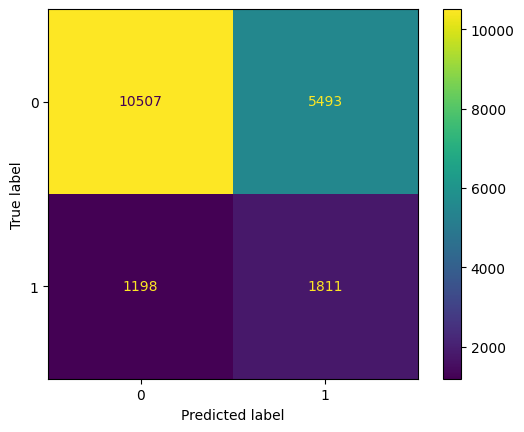

In [ ]:
cm = confusion_matrix(y_validation, (y_predict_val_proba[:, 1] > thresh[240]))
cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
recall_score(y_validation, (y_predict_val_proba[:, 1] > thresh[240]))

0.6018610834164174

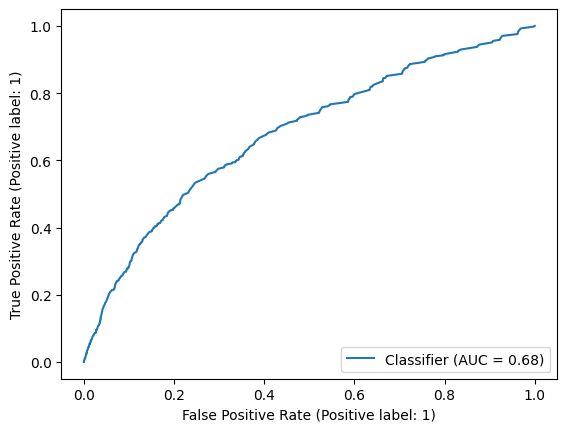

In [ ]:
fpr, tpr, thresholds = roc_curve(y_validation,(y_predict_val_proba[:, 1] > thresh[240]))


RocCurveDisplay.from_predictions(y_validation, y_predict_val_proba[:,1])


## 8. (1 pt) Finally, plot ROC-AUC and Confusion Matrix, and report the Recall value on the Test set.

In [ ]:
y_predict_test_proba = pipe.predict_proba(X_test)

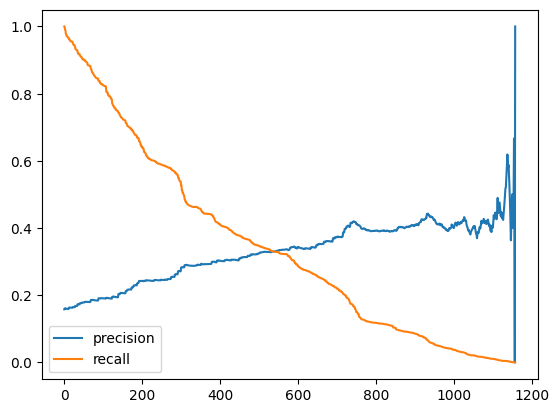

In [ ]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
precision, recall, thresh = precision_recall_curve(y_test, y_predict_test_proba[:, 1])
plt.plot(precision, label='precision')
plt.plot(recall, label='recall')
plt.legend()

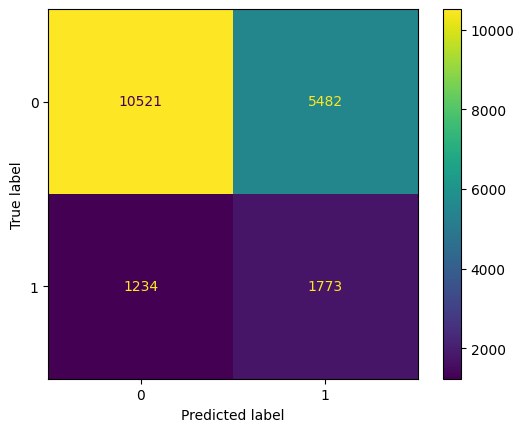

In [ ]:
cm = confusion_matrix(y_test, (y_predict_test_proba[:, 1] > threshold))
cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
recall_score(y_test, (y_predict_test_proba[:, 1] > thresh[240]))

0.591952111739275

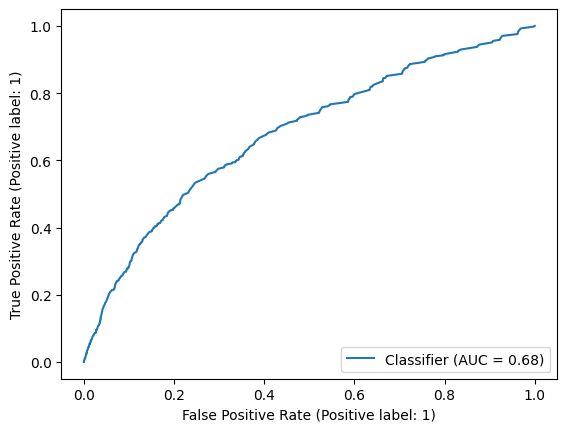

In [ ]:
fpr, tpr, thresholds = roc_curve(y_validation,(y_predict_val_proba[:, 1] > threshold))


RocCurveDisplay.from_predictions(y_validation, y_predict_val_proba[:,1])

## 9. (1pt) Which features are more important?

In [ ]:
pd.DataFrame({'feature': pipe[:-1].get_feature_names_out(), 'weight': np.abs(pipe[-1].coef_[0]).tolist()}).sort_values('weight', ascending=False)

,feature,weight
2,OneHot__Sex_nan,0.274186
4,remainder__CharlsonIndex,0.229884
3,remainder__ClaimsTruncated,0.186827
1,OneHot__Sex_M,0.168028
5,remainder__LengthOfStay,0.100124
6,remainder__AgeAtFirstClaim,0.069811
0,OneHot__Sex_F,0.049893


#Part 2
##10. (5pt)

Discuss the effectiveness of each of the following ML models based on their stated accuracy. Which one is the best overall?

**a.** In a roulette game, a ball is dropped onto a spinning wheel and eventually lands in one of 38 slots. Using a camera and visual cues (the position of the wheel when the ball was dropped and its rotation speed, as well as the position and speed of the ball), an ML model can predict the slot that the ball will land in with an accuracy of 4%.

**b.** A robotic chicken crosses a busy road a thousand times per day. An ML model evaluates traffic patterns and predicts when this chicken can safely cross the street with an accuracy of 99.9%.

**c.** A deadly but curable disease affects 0.01% of the population. An ML model uses the results of a simple lab test as features and predicts this affliction with an accuracy of 99.99%.

##11. (1pt)
The KNN model appears simpler than logistic regression or linear regression for classification. Why is the separating surface in KNN more complex than in the case of linear models?

## Question 10:
**a**. This model is not effective at all, especially in the casino setting. If we simply compute the probability of a ball landing in a random slot, which is 1/38 which roughly equals 0.026, that is not very different from the 4% accuracy that the model operates with. In practice, there will probably be no difference at all, so this model is definitely not effective enough to be used for financial gain in a casino.

**b**. A 99.9% accuracy is a very desirable accuracy for any model. I think in the setting given the model is effective. If the robotic chicken crosses the road 1000 times, 999 of those will be safe while the other 1 is left to the chance. In any case, since the chicken is robotic it can probably be repaired.

**c**. A 99.99% accuracy is very high and would be desired in other scenarious, but for this application a probabilistic ML model might not be the best. Every test has some rate of false positives, and we don't want to diagnose someone with a deadly disease, even in the chance is 0.01%. 0.01% for 100,000 people is 10 individuals.

*Overall*, based on the reasoning above I believe that the best ML model is the one that was designed for the robotic chicken scenario.

##Question 11:
Linear regression and logistic regression are both based on the assumption that there is a linear relationship between the features and the target. Specifically for classification problems, the linear models produce a decision boundary which is represented by a line or a hyperplane in higher dimensions. KNN, in contrast, does not assume any linear relationships in the data. It does not try to draw a line to separate the classes. Rather, it just computes distances between data points and performs a simple vote based on the K number of nearest neighbors. This usually produces a non-linear separating surface